# Analyse Average Pooling Results obtained from consistency data
This notebook is used to help analyse and visulise data processed from the notebook **AvgPooling3DConsistencyData.ipynb** .
Typically tasks demonstrated here are:
- plotting of score histogram
- print locations that match a consistency score criteria
- show locations in a volume that match a consistency score criteria.

## Imports and helper functions 

In [2]:
#%matplotlib notebook
#Enables 3D plots to be interactive (rotation enabled)
#Comment this line if this is not required. Notebook (kernel) must also be restarted

import numpy as np
import matplotlib.pyplot as plt
import time
#import dask.array as da
import h5py
from mpl_toolkits.mplot3d import Axes3D #3D plotting

from ipywidgets import interact
import ipywidgets as widgets

In [3]:
def PadOriginalData(origdata, padindexes):
#Pads the original data by the number of indexes given
    newdatahdf5 = origdata[0][ padindexes:-padindexes , padindexes:-padindexes , padindexes:-padindexes]
    newZ= origdata[1][ padindexes:-padindexes , padindexes:-padindexes , padindexes:-padindexes]
    newY= origdata[2][ padindexes:-padindexes , padindexes:-padindexes , padindexes:-padindexes]
    newX= origdata[3][ padindexes:-padindexes , padindexes:-padindexes , padindexes:-padindexes]
    
    return (newdatahdf5 , newZ, newY, newX)

In [4]:
def GetIndicesFromOrigDataWithConsistencyScoreBetween(datatuple, cscore_low, cscore_high):
    ''' Get indices of original data where the consistency score is betwen cscore_low and cscore_high
    datatuple must be in format
        datatuple[0] : array with the results of the average pooling
        datatuple[1] , [2], [3] : Z,Y,X coordinates of the original data from where the average pooling was performed (corner?)
    '''
    
    #This is needed to prevent errors when using slider (native Python float values to numpy.float)
    cscore_low_np = np.float64(cscore_low)
    cscore_high_np = np.float64(cscore_high)
    
    data = datatuple[0]

    indexes = np.where( (data >= cscore_low_np) & (data <= cscore_high_np ) )
    #Values will be in format (example)
    # (array([52, 53, 54, 55, 56]), array([0, 0, 0, 0, 0]), array([283, 283, 283, 283, 283]))
    
    #Convert these indices to the original data indices
    i_zip = list(zip(indexes[0],indexes[1],indexes[2]))
    #This will convert to format (example)
    # [(52, 0, 283), (53, 0, 283), (54, 0, 283), (55, 0, 283), (56, 0, 283)]
    
    #print (i_zip)
    i_conv=[]
    c_score = []
    #Convert indices to the ones from original data
    for e1 in i_zip:
        #print (e1)
        iz = datatuple[1][ e1[0] , e1[1] , e1[2] ]
        iy = datatuple[2][ e1[0] , e1[1] , e1[2] ]
        ix = datatuple[3][ e1[0] , e1[1] , e1[2] ]

        i_conv.append( (iz,iy,ix))
        c_score.append( data[ e1[0] , e1[1] , e1[2] ] ) #The actual cons-score is also returned
    
    
    return i_conv, c_score

def GetIndicesFromOrigDataWithConsistencyScoreNear(datatuple, cscore, cwidth= 0.1):
    ''' Get indices of original data where the consistency score is between
    cscore-cwidth and and cscore-cwidth
    datatuple must be in format
        datatuple[0] : array with the results of the average pooling
        datatuple[1] , [2], [3] : Z,Y,X coordinates of the original data from where the average pooling was performed (corner?)
    '''
    cscore_low = cscore-cwidth/2
    cscore_high = cscore+cwidth/2
    
    return GetIndicesFromOrigDataWithConsistencyScoreBetween(datatuple, cscore_low, cscore_high)

In [5]:
def PlotZYXPointFromList(points3Dlist):
    #Function to visualise location 3D points from a list of coordinates given
    
    fig = plt.figure(figsize=(4,3))
    ax = fig.add_subplot(111, projection='3d')
    
    for p0 in points3Dlist:
        ax.scatter(p0[2], p0[1], p0[0], marker = ',', color='blue')
    ax.set_xlabel('X index')
    ax.set_ylabel('Y index')
    ax.set_zlabel('Z index')

In [6]:
def PlotRegionsWhereRelatScoreConsistencyIs(relvalue0to1 , relwidth=0.1 , bPrintIndexes=False):
    ''' Plots 3D locations in a volume, where the Relative score consistency is between
    relvalue0to1-relwidth and relvalue0to1-relwidth
    
    bPrintIndexes: prints 3D locations found within the score region
    
    This function is designed to be used with interactivity in plots.
    Global variables origdata, minValue and maxValue must be predefined
    '''
    
    abs_value = minValue + relvalue0to1*(maxValue-minValue)
    abs_precis_width = relwidth *(maxValue-minValue)
    print ("abs_value =", abs_value , ", abs_precis_width=", abs_precis_width)
    listofindexes , _ = GetIndicesFromOrigDataWithConsistencyScoreNear(origdata, abs_value, abs_precis_width )
    PlotZYXPointFromList(listofindexes)
    if bPrintIndexes:
        print (listofindexes)
    
def PlotRegionsWhereScoreConsistencyIsBetween(value_low , value_high, bPrintIndexes=False):
    ''' Plots 3D locations in a volume, where the score consistency is between
    value_low and value_high
    
    bPrintIndexes: prints 3D locations found within the score region
    
    This function is designed to be used with interactivity in plots.
    Global variables origdata, minValue and maxValue must be predefined
    '''
    listofindexes, _ = GetIndicesFromOrigDataWithConsistencyScoreBetween(origdata, value_low, value_high )
    PlotZYXPointFromList(listofindexes)
    if bPrintIndexes:
        print (listofindexes)

## Loading data

In [7]:
#Type the correct filename here
f = h5py.File('2020-04-09_final_4_volumes_combined_VolAvg_k256_s128.h5','r')
print ("file details")
list (f.keys())

file details


['X', 'Y', 'Z', 'data']

In [8]:
f.keys()

<KeysViewHDF5 ['X', 'Y', 'Z', 'data']>

In [7]:
datahdf5 =  f['data']
print (datahdf5.shape)
X = f['X']
Y = f['Y']
Z = f['Z']
origdata= (datahdf5, Z , Y, X) #Keep average pooling data and corresponding indexes together in this tuple

(15, 18, 18)


In [8]:
#Find minimum and maximum score values
#These values will be useful later
minValue = np.amin(datahdf5)
maxValue = np.amax(datahdf5)
print("minValue=", minValue)
print("maxValue=", maxValue)

minValue= 15.479485034942627
maxValue= 35.796614587306976


## Analysis

### Histogram of consistency scores

In [9]:
#histogram of intensities
datahdf5_hist, binsedge = np.histogram(datahdf5 , bins='auto')

Text(0, 0.5, 'Counts')

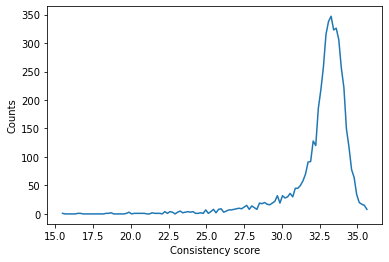

In [10]:
datahdf5_hist_x = binsedge[:-1]
plt.plot(datahdf5_hist_x , datahdf5_hist)
plt.xlabel('Consistency score')
plt.ylabel('Counts')

### Padding data example

In [11]:
paddeddata = PadOriginalData(origdata,2) # pad data by n indexes, to avoid borders

In [12]:
#histogram of intensities
paddeddata_hist, binsedge = np.histogram(datahdf5 , bins='auto')

Text(0, 0.5, 'Counts')

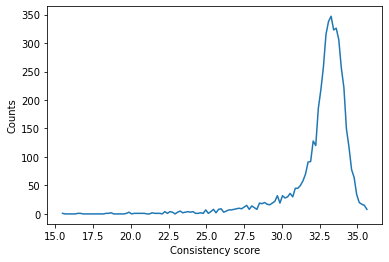

In [13]:
plt.plot(binsedge[:-1],paddeddata_hist)
plt.xlabel('Consistency score')
plt.ylabel('Counts')

In [14]:
#Find minimum and maximum values indices
minValuePad = np.amin(paddeddata[0])
maxValuePad = np.amax(paddeddata[0])
print("minValuePad=", minValue)
print("maxValuePad=", maxValue)

minValuePad= 15.479485034942627
maxValuePad= 35.796614587306976


### Extracting indexes (text)

In [15]:
print("Indices at minimum value")
print(GetIndicesFromOrigDataWithConsistencyScoreNear(origdata, minValue))

Indices at minimum value
([(512, 128, 2304)], [15.479485034942627])


In [16]:
print("Indices at 1/4 score value = ", str((maxValue-minValue)*0.25+minValue )  )
listof_IndexQuarters , _ = GetIndicesFromOrigDataWithConsistencyScoreNear(origdata, (maxValue-minValue)*0.25+minValue,0.1 )
print( listof_IndexQuarters )

Indices at 1/4 score value =  20.558767423033714
[(1920, 1664, 256)]


### 3D plots of score indexes locations

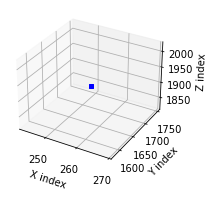

In [17]:
PlotZYXPointFromList(listof_IndexQuarters)

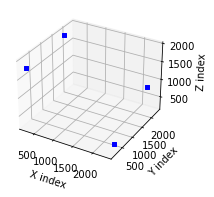

In [18]:
listof_IndexHalfs , _ = GetIndicesFromOrigDataWithConsistencyScoreNear(origdata, (maxValue-minValue)*0.5+minValue ,0.1)
PlotZYXPointFromList(listof_IndexHalfs)

Plot with slider

abs_value = 17.511197990179063 , abs_precis_width= 2.031712955236435


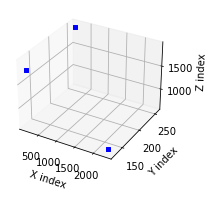

In [19]:
PlotRegionsWhereRelatScoreConsistencyIs(0.1)

abs_value = 25.6380498111248 , abs_precis_width= 2.031712955236435


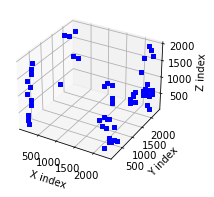

In [20]:
PlotRegionsWhereRelatScoreConsistencyIs(0.5)

abs_value = 31.733188676834107 , abs_precis_width= 2.031712955236435


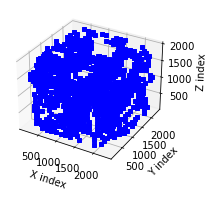

In [21]:
PlotRegionsWhereRelatScoreConsistencyIs(0.8)

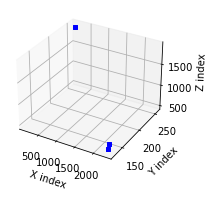

In [22]:
PlotRegionsWhereScoreConsistencyIsBetween(minValue , minValue+2.0)

### Interactive 3D plots of score indexes locations

In [23]:
interact(PlotRegionsWhereScoreConsistencyIsBetween, \
         value_low = widgets.FloatSlider(value=minValue, min=minValue, max=maxValue , continuous_update=False ) , \
         value_high = widgets.FloatSlider(value= (minValue+0.1), min=minValue, max=maxValue , continuous_update=False )
        )

interactive(children=(FloatSlider(value=15.479485034942627, continuous_update=False, description='value_low', …

<function __main__.PlotRegionsWhereScoreConsistencyIsBetween(value_low, value_high, bPrintIndexes=False)>

In [24]:
interact(PlotRegionsWhereRelatScoreConsistencyIs, \
         relvalue0to1 = widgets.FloatSlider(value=0.0, min=0.0, max=1.0, step=0.01 , continuous_update=False ) , \
         relwidth = widgets.FloatSlider(value= 0.1, min=0.0, max=0.5,step=0.025, continuous_update=False )
        )

interactive(children=(FloatSlider(value=0.0, continuous_update=False, description='relvalue0to1', max=1.0, ste…

<function __main__.PlotRegionsWhereRelatScoreConsistencyIs(relvalue0to1, relwidth=0.1, bPrintIndexes=False)>

## Select regions automatically and generate report
TODO: Identify regions within the histogram that would be good to segment.
1. Region near leftmost edge of histogram
2. Regions between leftmost edge and peak
2. Regions between leftmost edge and peak
4. Region on the rising slope of the histogram.
5. Top of histogram


In [25]:
#get x-consistency score where histogram is maximum
hist_vmax = np.amax(datahdf5_hist)

In [26]:
hist_x_vmax = datahdf5_hist_x[ np.where(datahdf5_hist == hist_vmax)[0] ]
print(hist_x_vmax)
#Choose regions based in the histogram shape

[33.25697339]


In [27]:
hist_xmin = np.min(datahdf5_hist_x)
hist_xmax = np.max(datahdf5_hist_x)
print(hist_xmin , hist_xmax)

15.479485034942627 35.627305174370605


In [48]:
from scipy import optimize

#Approximate peak with gaussian
def fgaussian(x, amplitude, mean, stddev):
    return amplitude * np.exp( -0.5 * ((x - mean) / stddev)**2 )

aguess= np.max(datahdf5_hist)
mguess = hist_x_vmax[0]
popt, pcov = optimize.curve_fit(fgaussian, datahdf5_hist_x , datahdf5_hist, [aguess, mguess, 1.0])

In [49]:
#popt will contain the estimated values as follows
# [0] amplitude , [1] mean, [2] stdev
# the mean should be similar to hist_x_vmax calculated earlier
print(popt)

[336.99165969  33.27826868   0.84213205]


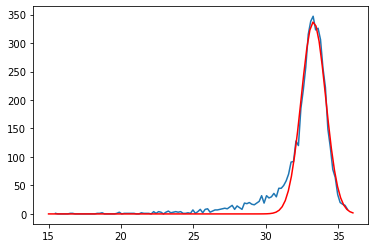

In [50]:
#Check fitting visually
xgauss=np.linspace(15,36, 100)
ygauss = fgaussian( xgauss , popt[0], popt[1],popt[2])

plt.plot(datahdf5_hist_x,datahdf5_hist)
plt.plot(xgauss, ygauss , color='r')


### Consistency auto-locations

In [66]:
# Automatically find volumes (their centers) which have consistency scores near a value hx
# hx values are chosen based in the shape of theconsistency score histogram and peak location
# Peak is fitted to a gaussian.

#Commonest consistency
hx5 = popt[1]

#At FWHM going up
hx4 = popt[1] - popt[2]*2.35482 /2 # FHWM = 2.35482*stdev 

#At mean - 3*stdev (3 sigma)
hx3 = popt[1] - 3* popt[2]

#Somewhere halfway between max and min
hx2 = (hist_xmax + hist_xmin)/2.0

hx1 = (hist_xmax - hist_xmin)/4 + hist_xmin

In [67]:
import math
def getClosestlVoxelFromListOfIndices(listindices_c, Zc,Yc,Xc):
    #From the list of voxel indices, get the closest voxel to point (Xc, Yc, Zc)
    listindices = listindices_c[0]
    listcscores = listindices_c[1]
    
    #First element sets the return result (default)
    if len(listindices) >0:
        voxelresult = listindices[0]
        voxelresult_dist = (voxelresult[0]-Zc)**2 + (voxelresult[1]-Yc)**2 + (voxelresult[2] - Xc)**2
        voxel_cscore = listcscores[0]
        
        if len(listindices)>1:
            for j0 in range(1, len(listindices)):
                i0 =  listindices[j0]
                #print( "i0= " , i0)
                thisdist = math.sqrt( (i0[0]-Zc)**2 + (i0[1]-Yc)**2 + (i0[2] - Xc)**2 )
                if thisdist<voxelresult_dist:
                    voxelresult = i0
                    voxelresult_dist = thisdist
                    voxel_cscore = listcscores[j0]
        
        #print ("Closest voxel is ", voxelresult , " with distance ", voxelresult_dist)
        return voxelresult, voxelresult_dist, voxel_cscore

In [68]:
Zcenter = int( (np.amax(Z) - np.amin(Z)) /2 )
Ycenter = int( (np.amax(Y) - np.amin(Y)) /2 )
Xcenter = int( (np.amax(X) - np.amin(X)) /2 )

In [69]:
point5 = getClosestlVoxelFromListOfIndices ( \
    GetIndicesFromOrigDataWithConsistencyScoreNear(origdata, hx5, popt[2] / 4 ), \
    Zcenter , Ycenter, Xcenter)

In [70]:
point4 = getClosestlVoxelFromListOfIndices ( \
    GetIndicesFromOrigDataWithConsistencyScoreNear(origdata, hx4, popt[2] / 4 ), \
    Zcenter , Ycenter, Xcenter)

In [71]:
point3 = getClosestlVoxelFromListOfIndices ( \
    GetIndicesFromOrigDataWithConsistencyScoreNear(origdata, hx3, popt[2] / 4 ), \
    Zcenter , Ycenter, Xcenter)

In [72]:
point2 = getClosestlVoxelFromListOfIndices ( \
    GetIndicesFromOrigDataWithConsistencyScoreNear(origdata, hx2, popt[2] / 4 ), \
    Zcenter , Ycenter, Xcenter)

In [73]:
point1 = getClosestlVoxelFromListOfIndices ( \
    GetIndicesFromOrigDataWithConsistencyScoreNear(origdata, hx1, popt[2] / 4 ), \
    Zcenter , Ycenter, Xcenter)

Regions of interest are the 256x256x256 with centres at the following locations

In [74]:
print ("Center location with bad consistency " , point1[0])
print ("Center location with bad-mid consistency " , point2[0])
print ("Center location with mid consistency " , point3[0])
print ("Center location with half-commonest consistency " , point4[0])
print ("Center location with commonest consistency " , point5[0])

Center location with bad consistency  (1920, 1664, 256)
Center location with bad-mid consistency  (640, 256, 128)
Center location with mid consistency  (768, 768, 1152)
Center location with half-commonest consistency  (768, 1280, 1152)
Center location with commonest consistency  (896, 1024, 1152)


In [75]:
def point_ReportResultAs_Vol_Center_CScore(p3d , width):
    w2 = int(width/2)
    
    p = p3d[0] #First element is the voxel coordinates
    point_dist = p3d[1] #Second element is the distance to...
    point_cscore = p3d[2] #Second element is the consistency score
    
    s = "[ " + str(p[0]-w2) + ":" + str(p[0]+w2) + " , " + \
        str(p[1]-w2) + ":" + str(p[1]+w2) + " , " + \
        str(p[2]-w2) + ":" + str(p[2]+w2) + \
        " ]"
    s +=  " centered at " + str(p)
    s += " cscore=" + str(point_cscore)
    return s

In [76]:
print ("Volume region with bad consistency " , point_ReportResultAs_Vol_Center_CScore(point1, 256) )
print ("Volume region with bad-mid consistency " , point_ReportResultAs_Vol_Center_CScore(point2, 256) ) 
print ("Volume region with mid consistency " , point_ReportResultAs_Vol_Center_CScore(point3, 256) )
print ("Volume region with half-commonest consistency " , point_ReportResultAs_Vol_Center_CScore(point4, 256) )
print ("Volume region with commonest consistency " , point_ReportResultAs_Vol_Center_CScore(point5, 256) )

Volume region with bad consistency  [ 1792:2048 , 1536:1792 , 128:384 ] centered at (1920, 1664, 256) cscore=20.512474536895752
Volume region with bad-mid consistency  [ 512:768 , 128:384 , 0:256 ] centered at (640, 256, 128) cscore=25.529066383838654
Volume region with mid consistency  [ 640:896 , 640:896 , 1024:1280 ] centered at (768, 768, 1152) cscore=30.682079195976257
Volume region with half-commonest consistency  [ 640:896 , 1152:1408 , 1024:1280 ] centered at (768, 1280, 1152) cscore=32.287492752075195
Volume region with commonest consistency  [ 768:1024 , 896:1152 , 1024:1280 ] centered at (896, 1024, 1152) cscore=33.244472205638885


### Plot histogram with relevant points highlighted

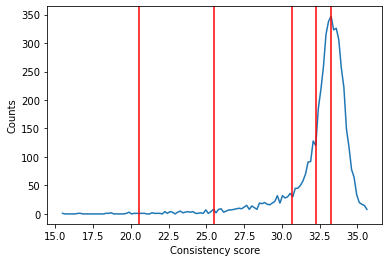

In [77]:
plt.plot(binsedge[:-1],paddeddata_hist)
plt.xlabel('Consistency score')
plt.ylabel('Counts')
plt.axvline(point1[2], label='point1', color='red')
plt.axvline(point2[2], label='point2', color='red')
plt.axvline(point3[2], label='point3', color='red')
plt.axvline(point4[2], label='point4', color='red')
plt.axvline(point5[2], label='point5', color='red')